# FIT5148 Assignment 2
#### Task C3

* Due: 24/05/2019
* Tutor: Paras Sitoula, Wednesday 12-2pm
<br>

| Student 1 | Student 2|
|-----------|----------|
| Hitesh Get | Samuel Campbell |

<br>

<dl>
    <dt><u>Please Note:</u></dt>
    <dd>Task 3A relies on the streaming data generated by Assignment_TaskC_Producer1.</dd>
    <dd>Task 3Bi accesses the data generated by Assignment_TaskA_B, please ensure that the environment is appropriately prepared.</dd>
</dl>

## 1. Import Necessary Modules

In [ ]:
import os
import csv
import pymongo
from pymongo import MongoClient
from datetime import datetime
import geohash as gh
import random as rand
from pprint import pprint
from time import sleep
from kafka import KafkaConsumer
import datetime as dt
import json
import matplotlib.pyplot as plt

# This line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

## 2. (3A) Streaming Data Visualisation

In [ ]:
def annotate_max(x, y, ax = None):
    """
    Plots the maxima
    """
    
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Time={}, Value={}'.format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.05),)
    
def annotate_min(x, y, ax = None):
    """
    Plots the minima
    """
    
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Time={}, Value={}'.format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='orange', shrink=0.05),)

def connect_kafka_consumer():
    """
    Connects to the Kafka stream
    """
    
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=10000, # Stop iteration if no message after 10 sec
                                   auto_offset_reset='earliest',
                                   bootstrap_servers=['localhost:9092'],
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

def init_plots():
    """
    Generates an empty plot to be populated
    """
    
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # Create new figure
        ax = fig.add_subplot(111) # Add the subplot axes to the given grid position
        fig.suptitle('Real-time Uniform Stream of Climate Data With Extrema Plotted')
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        ax.set_ylim(0,50) 
        ax.set_yticks([0,10,20,30,40,50])
        fig.show() # Display the figure
        fig.canvas.draw() # Draw on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))
    
def consume_messages(consumer, fig, ax):
    """
    As streaming data are encountered, their values are added to the plot, and the earliest value removed
    """
    
    try:
        x, y = [], [] # Containers for x and y values

        for message in consumer:
            # Decodes the data and reformats it JSON objects for easy access
            data = json.loads(", ".join(message.value.decode('utf-8').split(", ")))

            x.append(data['Time_Stamp'].split(" ")[1]) 
            y.append(int(data['Climate']['air_temperature_celcius']))

            if len(y) > 10: # When there are at least 10 data points, plot
                ax.clear()
                ax.plot(x, y)
                ax.set_xlabel('Time')
                ax.set_ylabel('Value')
                ax.set_ylim(0,50) 
                ax.set_yticks([0,10,20,30,40,50])
                annotate_max(x,y)
                annotate_min(x,y)
                fig.canvas.draw()
                x.pop(0) # Remove the item in the first position
                y.pop(0) # As above
        plt.close('all')
        
    except Exception as ex:
        print(str(ex))
    
# run
if __name__ == '__main__':
    
    topic = 'climate'
    
    consumer = connect_kafka_consumer()
    fig, ax = init_plots()
    consume_messages(consumer, fig, ax)

## 3. (3B) Static Data Visualisation
### (i) Fires Over the Course of a Day

<IPython.core.display.Javascript object>


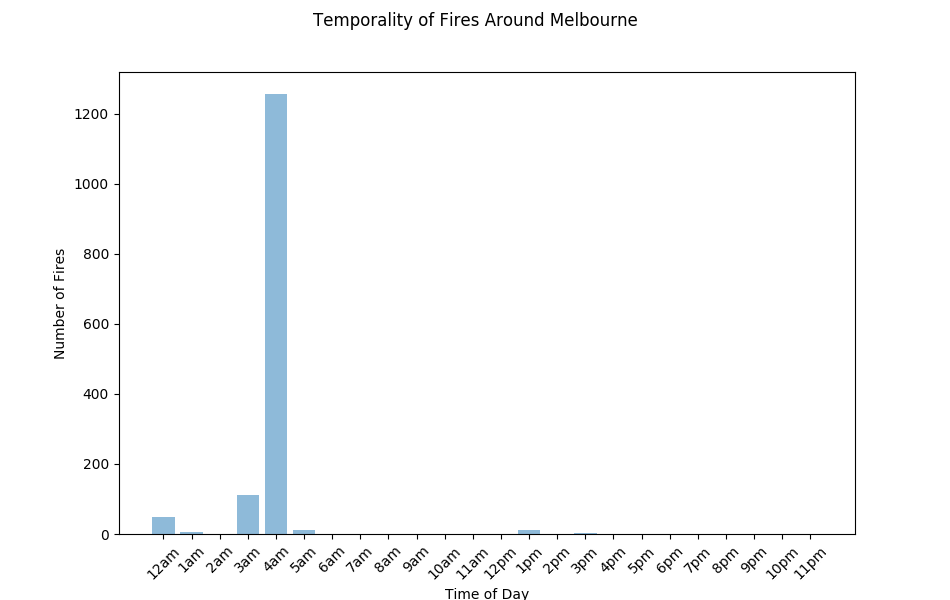

Text(0, 0.5, 'Number of Fires')

In [98]:
# Pulls the static data created in file Assignment_TaskA_B
result = MongoClient().fit5148_db.climate.aggregate([
    {'$project': {
        'hotspot.datetime': 1,
        'number_of_fires': {'$size': '$hotspot'},
        '_id': 1
    }},
    {'$sort': {'number_of_fires': pymongo.DESCENDING}},
    {'$limit': 10}
])

# Prepares the x axis labels and y axis values
times = [str(j) + "am" for j in [12] + [i for i in range(1,12)]] + [str(j) + "pm" for j in [12] + [i for i in range(1,12)]]
fires = [0 for i in range(0,24)]

# Sums over values, increasing relevant y axis values each time a particular hour is encountered
for i in result:
    for j in i['hotspot']:
        fires[int(j['datetime'].split('T')[1][0:-6])] += 1

# Preps and prints plot
y_pos = np.arange(len(times))
width = 9.5
height = 6
fig = plt.figure(figsize=(width,height)) # Create new figure
ax = fig.add_subplot(111) # Adding the subplot axes to the given grid position
ax.bar(times, fires, align='center', alpha=0.5)
plt.xticks(rotation=45)
fig.suptitle('Temporality of Fires Around Melbourne') # Giving figure a title
ax.set_xlabel('Time of Day')
ax.set_ylabel('Number of Fires')

## 4. (ii) Fire Locations

In [ ]:
import gmplot
import webbrowser

# Instantiates the map and setting it to Victoria's centroid (per https://bit.ly/2VN4rPx)
gmap = gmplot.GoogleMapPlotter(
    -36.85416666666667, # Latitude
    144.28111111111113, # Longitude
    7 # Zoom
)

# Instantiates a bin for the data
map_data = []

# Pull the data from task B1
for i in MongoClient().fit5148_db.climate.aggregate([
    {'$unwind': '$hotspot'}
]):
    # Add location and characteristics to the map
    gmap.marker(
        i['hotspot']['latitude'], 
        i['hotspot']['longitude'], 
        'red', # Marker colour
        title = ( # Tooltip
            "Air Temperature (Celsius): " + str(i['climate']['air_temperature_celsius']) + ", " +
            "Surface Temperature (Celsius): " + str(i['hotspot']['surface_temperature_celsius']) + ", " +
            "Confidence: " + str(i['hotspot']['confidence']) + ", " +
            "Relative Humidity: " + str(i['climate']['relative_humidity'])
        )
    )

# Draw the map
gmap.draw("fireMap.html")
webbrowser.open_new("fireMap.html")